In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as spc
import astrosme

# Output images in this notebook
%matplotlib inline

# AstroSME: Feature overview

## Introduction

**AstroSME** is a Python library to simulate the effects of physics beyond the Standard Model on the polarization state of photons arriving from astronomical sources according to the Standard Model Extension (SME) framework, search for SME effects in observed polarimetry and simulate potential bias imposed on the polarimetric measurements by the dust in the Milky Way.

The code was developed by Roman Gerasimov and Andrew Friedman at University of California San Diego.

This notebook gives a brief and superficial overview of SME and demonstrates the basic set of features provided by the library. See <a href="https://ui.adsabs.harvard.edu/abs/2009PhRvD..80a5020K/abstract">Kostelecký+2009</a> for a more general introduction (including non-astronomical contexts) and <a href="https://ui.adsabs.harvard.edu/abs/2020PhRvD.102d3008F/abstract">Friedman+2020</a> for a mathematical description of the library as well as pictorial discussion of the physical meanings of the quantities introduced here.

## Standard Model Extension 101

The photon dispersion relation in special relativity reads:

$$E=p$$

where $E$ is the energy of the photon, $p$ is its momentum and a system of units is adopted such that $\hbar=c=1$. **Standard Model Extension** (SME) operates by adding operators to the Standard Model Lagrangian, allowing deviations from the above dispersion relation at very high energies, where standard relativistic physics breaks down and a currently unknown theory of quantum gravity manifests itself. Mathematically, SME works in the photon sector by adding more terms to the dispersion relation as follows:

$$E=\left(1-\varsigma^{(0)}\pm\sqrt{(\varsigma^{(1)})^2 + (\varsigma^{(2)})^2 + (\varsigma^{(3)})^2}\right)p$$

The quantities $\varsigma^{(0)}$, $\varsigma^{(1)}$, $\varsigma^{(2)}$ and $\varsigma^{(3)}$ can depend on the energy of the photon and the direction of its arrival (astronomically speaking, the bandpass of the observation and the celestial coordinates of the emitter). Physically, non-zero values of those quantities will violate certain symmetries required by the Theory of Relativity and the Standard Model of physics. For example, a universe where $\varsigma^{(0)}\ne 0$ displays *vacuum dispersion* (dependence of the speed of light on photon energy). On the other hand, all of $\varsigma^{(1)}$, $\varsigma^{(2)}$ and $\varsigma^{(3)}$ allow *vacuum birefringence*, which results in the polarization properties of photons gradually changing as they are traveling through vacuum.

In order to make this construction work as intended, certain constraints are imposed on how $\varsigma^{(0)}$, $\varsigma^{(1)}$, $\varsigma^{(2)}$ and $\varsigma^{(3)}$ are allowed to depend on energy and direction. For example, $\varsigma^{(0)}$ must be an *even* function of energy, while $\varsigma^{(3)}$ must be an *odd* one. $\varsigma^{(1)}$ and $\varsigma^{(2)}$ are both *even* functions of energy, but they differ from $\varsigma^{(0)}$ in the symmetries obeyed by their directional dependence. We will omit the exact physical reasoning behind those restrictions here, merely emphasizing that they motivate the form of the dispersion relation and make non-zero values produce intended physical effects.

For further convenience, the dependency of $\varsigma$ on energy is expanded as a polynomial. For example, for $\varsigma^{(0)}$:

$$\varsigma^{(0)}=\varsigma^{(0,0)}+E^2\varsigma^{(0,2)}+E^4\varsigma^{(0,4)} + E^6\varsigma^{(0,6)}+\ldots$$

where all odd terms were excluded to satisfy the aforementioned constraint on $\varsigma^{(0)}$. Furthermore, the physical effects caused by different terms in the equation above are assumed to have vastly different scales, which means that at all times only one of $\varsigma^{(0,0)}, \varsigma^{(0,2)}, \varsigma^{(0,4)},\ldots$ is expected to be dominant. Therefore, we can simplify the equation as:

$$\varsigma^{(0)}\approx E^{d-4}\varsigma^{(0,d-4)}$$

where $d$ is some fixed integer representing the dominant term. As it is not clear which $d$ is most appropriate for our universe, simulations for various values of $d$ must be performed and compared to observations. The quantity $d$ is usually referred to as the *mass dimension* of the theory that is being approximated by SME, as it corresponds to the mass dimension of the dominant SME term in the Lagrangian.

Finally, all of $\varsigma^{(0,d-4)}$, $\varsigma^{(1,d-4)}$, $\varsigma^{(2,d-4)}$ and $\varsigma^{(3,d-4)}$ are written as linear combinations of spin-weighted spherical harmonics with the directional dependence of the quantities entirely determined by the corresponding **complex** coefficients that are usually denoted with $k^{(d)}_{(X)jm}$, where $X$, $j$ and $m$ span over a finite set of values, dependent on the mass dimension $d$ and on the specific $\varsigma$ under consideration. **AstroSME** will identify all allowed values of $X$, $j$ and $m$ automatically as necessary.

## Mission statement

Our ultimate aim is to conduct astronomical observations to determine the values of the coefficients appearing in front of the spherical harmonics in the expanded SME dispersion relation ($k^{(d)}_{(X)jm}$). Since the physical effects of the SME are expected to be very subtle, it is possible that the coefficients are too close to $0$ to be measured with the current generation of astronomical equipment. In such case, our aim must be adjusted to establish the upper limits on the SME coefficients instead of finding their actual values.

In principle, multiple types of astronomical measurements are suitable for the purpose. **AstroSME** specifically focuses on polarization measurements, which means that $\varsigma^{(0)}$ cannot be constrained by our analysis as this quantity does not affect polarization. Instead, our approach will focus on constraining $\varsigma^{(1)}$, $\varsigma^{(2)}$ and $\varsigma^{(3)}$. Since, $\varsigma^{(3)}$ is an odd function of $E$ by construction, it must be equal to $0$ for all $d$-even universes and does not need to be constrained. Likewise, $\varsigma^{(1)}$ and $\varsigma^{(2)}$ are not applicable in $d$-odd universes. **AstroSME** takes the desired mass dimension as input and automatically determines all expansion coefficients that can be non-zero.

While an appropriate value of $d$ cannot be known a priori, multiple possible values can be tested individually. The total number of non-zero SME coefficients that need to be constrained grows with $d$, requiring more and more astronomical data at higher mass dimensions. For this reason, it is often necessary to restrict exploration to a few lowest values of $d$, such as $4$, $5$ and $6$.

The process of constraining SME coefficients can be written out in three simple steps:

1. Choose a mass dimension and guess some small values for the coefficients that may be non-zero.
2. Simulate the astronomical polarization effects that would be expected if the guessed values were correct.
3. Compare the simulated results to the actual measurements and adjust the guesses accordingly.

The steps must be repeated until a satisfactory convergence is achieved. In this notebook, we will first demonstrate how various SME effects can be simulated using **AstroSME** and how they change with the adopted coefficient values and mass dimensions. Then, it will be demonstrated how those simulations can be used to determine the desired constraints.

## Create universes

To simulate SME effects, one must first use **AstroSME** to create a `Universe()` object, populated with the desired mass dimension and SME coefficients.

The cell below creates 9 universes with $d=4$, $d=5$ and $d=6$; three universes per dimension. For each dimension, we will create one universe with no SME effects (all SME coefficients are $0$), one universe with weak SME (small coefficients) and one universe with strong SME (large coefficients).

All SME coefficients are given in the units of $\mathrm{eV}^{4-d}$.

In [3]:
np.random.seed(42)        # Ensure consistent output for the demo notebook

universes = list(np.full([3, 3], None))
for i, d in enumerate([4, 5, 6]):
    for j, average_k in enumerate([0.0, 5e-34, 1e-33]):
        universes[i][j] = astrosme.Universe(d)
        # Get the number of coefficients in this universe
        number_of_k = len(universes[i][j].k)
        # Initiate all coefficients at random
        universes[i][j].k = np.random.uniform(-average_k, average_k, number_of_k)
        print("Spawned dimension-{} universe with {} SME coefficients".format(d, number_of_k))

Spawned dimension-4 universe with 10 SME coefficients
Spawned dimension-4 universe with 10 SME coefficients
Spawned dimension-4 universe with 10 SME coefficients
Spawned dimension-5 universe with 16 SME coefficients
Spawned dimension-5 universe with 16 SME coefficients
Spawned dimension-5 universe with 16 SME coefficients
Spawned dimension-6 universe with 42 SME coefficients
Spawned dimension-6 universe with 42 SME coefficients
Spawned dimension-6 universe with 42 SME coefficients


Note how universes of higher mass dimensions require more non-zero SME coefficients.

We can easily see what coefficients those universes were spawned with by calling `.get_k_real()` or `.get_k_complex()`. The cell below takes one of the universes, extracts all its coefficients and prints them alongside the labels indicating which spherical harmonic each coefficient refers to:

In [4]:
coefficients = universes[0][2].get_k_real()
for coefficient in coefficients:
    print('{}: {}'.format(coefficient, coefficients[coefficient]))

(k_(E)2,0): 2.23705789444759e-34
(Re[k_(E)2,1]): -7.210122786959163e-34
(Im[k_(E)2,1]): -4.1571070292956375e-34
(Re[k_(E)2,2]): -2.672763134126166e-34
(Im[k_(E)2,2]): -8.786003156592811e-35
(k_(B)2,0): 5.703519227860272e-34
(Re[k_(B)2,1]): -6.0065243568328055e-34
(Im[k_(B)2,1]): 2.8468876827223195e-35
(Re[k_(B)2,2]): 1.8482913772408487e-34
(Im[k_(B)2,2]): -9.070991745600046e-34


Even more convenient, we can immediately typeset this in LaTeX with just one minor change in the code:

In [5]:
# To print LaTeX into the notebook..
from IPython.display import display, Math

coefficients = universes[0][2].get_k_complex(latex = True)
for coefficient in coefficients:
    display(Math('{}= ({:.2f})\\times10^{{-34}}'.format(coefficient, coefficients[coefficient] * 1e34)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Photon ping pong

Now that we have 9 universes, let's start sending photons through them to see how SME affects astronomical polarization. Suppose that we have an astronomical source (presumably, a galaxy) at the following coordinates and redshift:

In [6]:
source = {
    'ra': 34.9,
    'dec': -60.8,
    'z': 3.6,
}

To simulate propagation of the photon from the source to the observer, use `.receive_photon()`. The function will need to know the energy of the photon (`E`) as well as its *initial* polarization fraction (`pol`) and angle (`psi`).

A similar function, `.send_photon()`, can reverse the process by taking the *observed* polarization properties and predicting their *initial* values as emitted by the source.

In [7]:
# Initial photon polarization (as emitted by the source)
psi = 35.0     # Angle
pol = 0.9      # Fraction
E = 1.2        # Energy (in eV)

print("The source has emitted a photon with psi={:.2f} and pol={:.2f}".format(psi, pol))
print("The photon will now be sent to the telscope...")

psi, pol = universes[0][2].receive_photon(**source, E = E, psi = psi, polarization_fraction = pol)

print("The telescope received a photon with psi={:.2f} and pol={:.2f}".format(float(psi), float(pol)))
print("The photon will now be sent back to the source...")

psi, pol = universes[0][2].send_photon(**source, E = E, psi = psi, polarization_fraction = pol)

print("The source received its photon back with psi={:.2f} and pol={:.2f}".format(float(psi), float(pol)))

The source has emitted a photon with psi=35.00 and pol=0.90
The photon will now be sent to the telscope...
The telescope received a photon with psi=54.83 and pol=0.83
The photon will now be sent back to the source...
The source received its photon back with psi=35.00 and pol=0.90


Of course, the above approach is hardly useful, as we do not normally know the initial polarization of the photon. We can only observe its final polarization after it completes the entire journey from the source and arrives at the telescope. In such case, it is perhaps more useful to look at how a *spectrum* of photons is affected by the SME instead of an individual photon.

In the cell below, we assume the initial spectrum to have the same polarization angle throughout. Since SME will affect photons of different wavelengths differently, we expect the received spectra to display a *drift* in the polarization angle across wavelengths. Hopefully, the rate of this drift is less dependent on the initial polarization, allowing us to remove this variable from consideration.

Text(0, 0.5, '$\\psi_m$ [deg]')

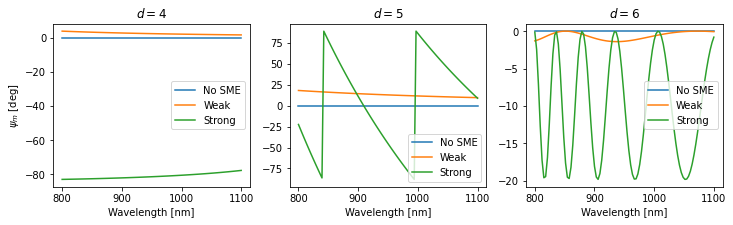

In [8]:
wavelength = np.linspace(800, 1100, 100)                # Spectrum ranges from 800 to 1100 nm
energy = spc.h * spc.c / (wavelength * 1e-9) / spc.e    # Convert to eV
psi_z = np.full(np.shape(energy), 0.0)                  # Initial source spectrum

fig, axes = plt.subplots(1, 3, figsize = [12, 3])

for i, d in enumerate([4, 5, 6]):
    for j, sme_strength in enumerate(['No SME', 'Weak', 'Strong']):
        # Receive photons at the telescope
        psi_m = universes[i][j].receive_photon(**source, E = energy, psi = psi_z)
        axes[i].plot(wavelength, psi_m, label = sme_strength)
        axes[i].set_xlabel('Wavelength [nm]');
    axes[i].set_title('$d={}$'.format(d))
    axes[i].legend()
axes[0].set_ylabel(r'$\psi_m$ [deg]')

For all "No SME" universes, no drift is observed and the observed spectrum is a flat straight line as expected. At stronger coefficients, the drift becomes more apparent and potentially measurable.

## Polarization drift and compatibility

To measure the expected polarization drift, one could take the plots produced above and calculate their slopes. **AstroSME** defines `.rho()` - a method that calculates the expected polarization drift (in $\textrm{deg/eV}$) for an arriving photon. Below, we plot those predictions for $d=4,5,6$ universes as a function of the first SME parameter (whatever it is for the given dimension), keeping all other SME parameters at zero.

As it turns out, in $d$-even universes, the polarization drift depends on the initial polarization angle of the source, which can be calculated from the observed polarization angle at the telescope. This dependency does not exist in $d$-odd universes. To highlight it, the cell below produces plots for three different *observed* polarization angles:

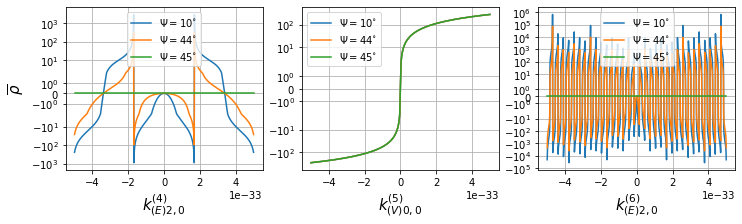

In [9]:
fig, axes = plt.subplots(1, 3, figsize = [12, 3])

for i, d in enumerate([3, 4, 5]):
    for psi in [10, 44, 45]:      # Make plots for different values of observed polarization angle
        x = np.linspace(-5e-33, 5e-33, 1000)   # Range of SME-coefficient values to plot
        y = []
        for value in x:
            # Test source at vernal equinox (0, 0) and z=1. We are considering E=2.26 eV photons
            test_source = {'ra': 0.00, 'dec': 0.00, 'z': 1.0, 'psi': psi, 'E': 2.26}
            # Set up the SME coefficients
            universes[i][0].k = np.zeros(len(universes[i][0].k))
            universes[i][0].k[0] = value

            # Calculate SME rotation
            y += [universes[i][0].rho(**test_source)]

    # Plotting...
        axes[i].plot(x, y, label = r'$\Psi=' + str(psi) + '^{\circ}$')
    first_k_label = list(universes[i][0].get_k_real(latex = True).keys())[0]
    axes[i].set_xlabel('${}$'.format(first_k_label), size = 15)
    axes[i].legend(); axes[i].grid(); axes[i].set_yscale('symlog')
axes[0].set_ylabel(r'$\overline{\rho}$', size = 15);

It must be emphasized that the simulations above relied on provided SME coefficients. Those are unknown in practice and the input coefficients are guesses to be corrected based on observed data. As such, it is useful to evaluate the probability that a given set of SME coefficients is compatible with a given astronomical measurement. A high value of such probability would indicate that our coefficient guesses are nearly correct, while a low value would call for a revision.

Suppose that the test source above was observed (at the telescope) to emit a photon with $\rho=0\pm 1\ \textrm{deg/eV}$ (polarization drift) at $2.26\ \textrm{eV}$ and $20$ degrees polarization. The `.compatibility()` method can estimate the probability that this observation is compatible with a given SME model. The cell below plots this probability for different values of the first SME coefficient.

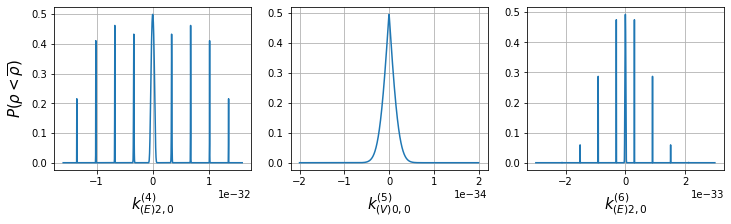

In [10]:
fig, axes = plt.subplots(1, 3, figsize = [12, 3])

for i, d in enumerate([3, 4, 5]):
    k_limit = [16, 0.2, 3]
    x = np.linspace(-k_limit[i] * 1e-33, k_limit[i] * 1e-33, 1000)
    y = []
    for value in x:
        test_source = {'ra': 0.00, 'dec': 0.00, 'z': 1.0, 'psi': 20.0, 'E': 2.26, 'rho': 0.0, 'e_rho': 1.0}
        universes[i][0].k = np.zeros(len(universes[i][0].k))
        universes[i][0].k[0] = value
        y += [universes[i][0].compatibility('spectropolarimetry', **test_source)]
    axes[i].plot(x, y)
    first_k_label = list(universes[i][0].get_k_real(latex = True).keys())[0]
    axes[i].set_xlabel('${}$'.format(first_k_label), size = 15)
    axes[i].grid()
axes[0].set_ylabel(r'$P(\rho < \overline{\rho})$', size = 15);

All plots above peak around $0$, suggesting that the most likely value of the first SME coefficient is $0$. However, one may still extract an upper limit on this value from the spread in the distribution, which is our original aim.

Before proceeding, we note that the probability distribution returned by `.compatibility()` will **always** peak at $0$ even if the observed data provide compelling evidence for non-zero SME coefficients. This is because the probability of compatibility is defined conservatively by assuming that the universe does not have any SME effects to begin with. As a result, `.compatibility()` can only be used to look for upper constraints on the coefficient values and cannot produce positive evidence. For latter, one may try to compare SME models against measurements as functions of redshift and / or position on the sky.


<div class="alert alert-info">

**Note:** only linear polarization is considered in this tutorial. The circular component (Stokes $V$) is assumed negligible at the source and unmeasured and irrelevant at the telescope. **AstroSME** however does feature basic support of circular SME tests which are described in an appendix.

</div>

## Broadband polarimetry

One way of constraining SME coefficients is by measuring the polarization drift, as explored above. However, this approach requires polarization measurements at different wavelengths, which are not always available. Where only one polarization value is given, SME coefficients may still be constrained by exploiting the fact that real polarization measurements are always performed over a broad range of wavelengths transmitted by the filter in the optical path.

The polarization drift within the observation band will scramble the polarization angles of individual photons, reducing the overall polarization fraction transmitted through this band. We may hope to be able to observe this depolarization effect in astronomical sources and use it to constrain SME coefficients.

To make progress, however, one will require the exact transmission profile of the instrument. As a test, we will use a simple boxcar transmission profile of a filter that is perfectly translucent between $570\ \mathrm{nm}$ and $730\ \mathrm{nm}$, but perfectly opaque elsewhere. To start, we will use **AstroSME** to create an `Instrument()` object and load the transmission profile into it as follows:

In [11]:
# Create a bunch of test universes of different dimensions
universe = {
    4: astrosme.Universe(4),
    5: astrosme.Universe(5),
    6: astrosme.Universe(6),
}

# Generate a boxcar transmission profile
wl = np.linspace(100, 1200, 11001)           # Grid of wavelengths (in nm)
t = np.zeros(len(wl))                        # Set transmission everywhere to 0.0
t[(wl > 570) & (wl < 730)] = 1.0             # Except for the 570..730 nm interval, where it is 1.0

# Create instrument objects for each universe
instruments = {
    4: universe[4].instrument(wl, t, name = 'boxcar-570-730'),
    5: universe[5].instrument(wl, t, name = 'boxcar-570-730'),
    6: universe[6].instrument(wl, t, name = 'boxcar-570-730'),
}

We can now use the `.pol_max()` method to predict the maximum allowed polarization for a given source observed through the instruments created above. As before, the value will depend on the observed polarization angle in $d$-even universes. The cell below explores how the maximum predicted polarization value varies with the observed polarization angle and the first SME coefficient, keeping all other coefficients at $0$ as before:

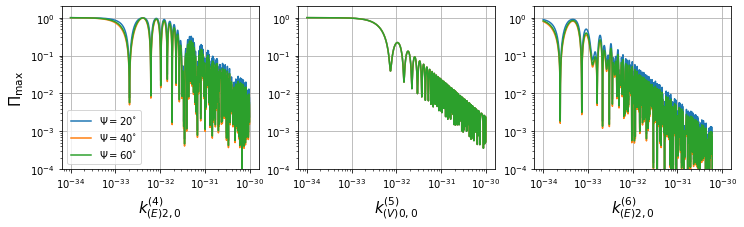

In [12]:
# Test source (some coordinates and redshift)
source = {
    'ra': 29.410,
    'dec': 16.881,
    'z': 1.06,
}

fig, axes = plt.subplots(1, 3, figsize = [12, 3])

for i, d in enumerate([4, 5, 6]):
    x = 10.0 ** np.linspace(-34, -30, 1000) # Range of SME coefficient values to plot
    for psi in [20, 40, 60]:                # Observed polarization angle to plot
        y = []
        for value in x:
            universe[d].k[0] = value # Set the first coefficient. Others will stay at 0 by default
            y += [universe[d].pol_max(**source, psi = psi, instrument = instruments[d])]
    
    # Plotting...
        axes[i].plot(x, y, label = r'$\Psi=' + str(psi) + '^{\circ}$')
    axes[i].set_xscale('log'); axes[i].set_ylim(1e-4, 2.0)
    axes[i].set_yscale('log')
    first_k_label = list(universe[d].get_k_real(latex = True).keys())[0]
    axes[i].set_xlabel('${}$'.format(first_k_label), size = 15)
    if i == 0:
        axes[i].set_ylabel(r'$\Pi_{\mathrm{max}}$', size = 15)
        axes[i].legend()
    axes[i].grid()

As one may expect, under weak SME coefficients no depolarization occurs, leaving the maximum polarization fraction at unity. As the coefficients grow higher, the depolarization effect manifests itself by lowering the value.

As before, our ultimate interest is aimed at the probability of compatibility of a given polarization measurements with a set of SME coefficients. Suppose that the source above was observed to have $\Pi=0.103\pm 0.025$ (polarization fraction). In this case, we can estimate the probability that a given set of SME coefficients is compatible with this observation as follows:

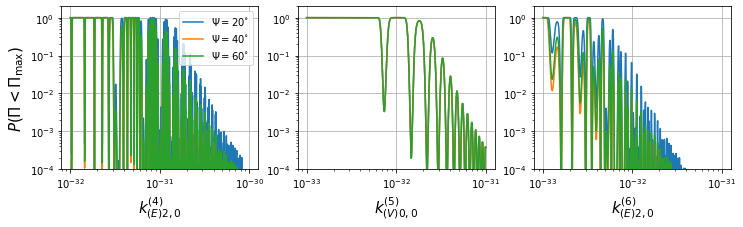

In [13]:
source['pol'] = 0.103
source['e_pol'] = 0.025

fig, axes = plt.subplots(1, 3, figsize = [12, 3])

k_ranges = [-32, -33, -33]
for i, d in enumerate([4, 5, 6]):
    x = 10.0 ** np.linspace(k_ranges[i], k_ranges[i] + 2, 1000)
    for psi in [20, 40, 60]:
        y = []
        for value in x:
            universe[d].k[0] = value
            y += [universe[d].compatibility('broadband', **source, psi = psi, instrument = instruments[d])]
        axes[i].plot(x, y, label = r'$\Psi=' + str(psi) + '^{\circ}$')
    axes[i].set_xscale('log'); axes[i].set_ylim(1e-4, 2.0)
    axes[i].set_yscale('log')
    first_k_label = list(universe[d].get_k_real(latex = True).keys())[0]
    axes[i].set_xlabel('${}$'.format(first_k_label), size = 15)
    if i == 0:
        axes[i].set_ylabel(r'$P(\Pi < \Pi_{\mathrm{max}})$', size = 15)
        axes[i].legend()
    axes[i].grid()

As before, the compatibility curves approach $1$ (fully compatible) in the weak SME limit due to the conservative definition.

## MCMC regression

Until now, we have used **AstroSME** to simulate SME polarization effects and evaluate the probability of compatibility between observed data and SME coefficients. Now, we will go beyond this by considering multiple astronomical measurements simultaneously instead of one at a time (compatibility probabilities will be multiplied together assuming all measurements to be independent) and by allowing the library to automatically determine how the SME coefficients need to be corrected to maximize said compatibility. For the latter, **AstroSME** relies on the Metropolis-Hastings Markov chain Monte Carlo (MCMC) algorithm implemented in a package called **emcee** (tested with version `3.0rc1`).

First, we must load all available astronomical measurements in. **AstroSME** stores catalogues of measurements in Python pickle files that can be loaded by creating a `Catalogue()` object as demonstrated in the cell below. In this notebook, we will use an already compiled and ready-to-go catalogue of measurements from [Kislat 2018](http://inspirehep.net/record/1709964). This catalogue includes both drift and broadband polarization measurements. Refer to a dedicated manual for guidance on creating and managing **AstroSME** catalogue files.

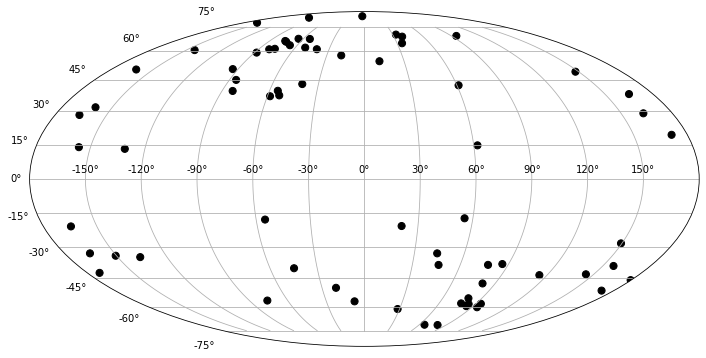

In [14]:
# Load the catalogue
cat = astrosme.Catalogue('catalogues/kislat_2018.pkl')

# Plot the astronomical sources included in the catalogue
cat.source_plot(galactic = True);

We also need to initialize all instruments from the catalogue and create a universe of some mass dimension. For the time being, we will consider a $d=4$ CPT-even universe.

In [15]:
my_universe = astrosme.Universe(4)

instruments = {}
for band in cat.bands.keys():
    params = cat.bands[band]
    # "theta_grid" and "theta_silent" parameters below allow pre-tabulation of certain calculations for
    # faster performance. Refer to the docstrings of the relevant functions for details
    instruments[band] = my_universe.instrument(params['wl'], params['t'], name = band, theta_grid = [500, 10000], theta_excess = 'silent')

With everything in place, we are ready to run the MCMC chain. We will need to specify the desired number of iterations, i.e. the number of times the chain will attempt to improve the guesses of the SME parameters before terminating with a final result.

Here, we will run a chain with only $10000$ iterations as a test; however, longer chains are recommended to obtain reliable results.

In [16]:
result = astrosme.mcmc_run(my_universe, cat, instruments, 10000)

Detected 8 CPUs
Estimating a suitable width for the proposal distribution
Estimated a suitable width for the proposal distribution as 3.511548639554129e-35
Will employ 20 MCMC walkers for 10000 trials

Executing trials...


100%|██████████| 500/500 [09:44<00:00,  1.17s/it]


 All done!


Execution time: 587.2824108600616 seconds
RAM usage: 0.763 MB
Acceptance rate: 0.2759


`result` now stores the histograms of every coefficient value explored in the chain. We can plot them all alongside $1\sigma$ (green) and $2\sigma$ (red) percentiles:

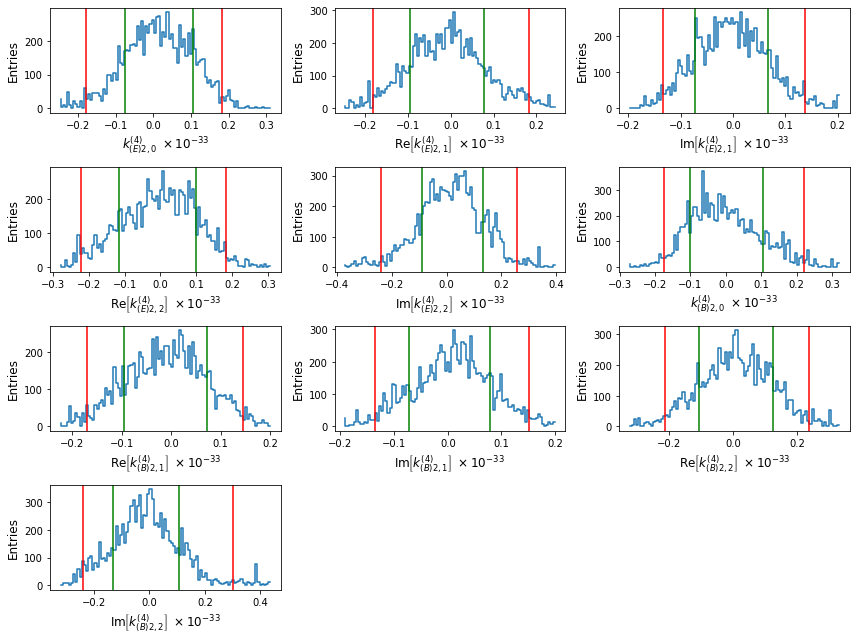

In [17]:
fig, axes = plt.subplots(4, 3, tight_layout = True, figsize = [12, 9])
fig.delaxes(axes[3][2]); fig.delaxes(axes[3][1]);
for i, hist in enumerate(result['histograms']):
    axes[int(i / 3)][int(i % 3)].step(result['histograms'][i][1][1:] / 1e-33, result['histograms'][i][0])
    axes[int(i / 3)][int(i % 3)].axvline(x = result['two_sigma_lower'][i] / 1e-33, color = 'r')
    axes[int(i / 3)][int(i % 3)].axvline(x = result['one_sigma_lower'][i] / 1e-33, color = 'g')
    axes[int(i / 3)][int(i % 3)].axvline(x = result['one_sigma_higher'][i] / 1e-33, color = 'g')
    axes[int(i / 3)][int(i % 3)].axvline(x = result['two_sigma_higher'][i] / 1e-33, color = 'r')
    axes[int(i / 3)][int(i % 3)].set_xlabel('$' + list(my_universe.get_k_real(latex = True).keys())[i] + r'\ \times 10^{-33}$', size = 12)
    axes[int(i / 3)][int(i % 3)].set_ylabel('Entries', size = 12)

## Appendix: Circular polarization

Previously, this tutorial walked through the main functionality of **AstroSME** that involved SME tests using linear polarization. Circular polarization is disregarded completely under two premises:

* The circular polarization is negligible ($V=0$) at all sources, which is partly motivated by theoretical studies such as [Matsumiya+2003](https://ui.adsabs.harvard.edu/abs/2003ApJ...595L..25M/abstract) that suggest that this is indeed the case in the optical regime.
* The circular polarization at the observer is ignored, as there is a shortage of data and incorporating any SME constraints from circular polarization would only make the results less conservative.

In reality, of course, circular polarization may be induced in-flight by SME effects even if the original value of $V$ is $0$. The absence of circular polarization at the telescope would in turn provide further constraints on the maximum strength of the SME. Here, we briefly consider the tools built within **AstroSME** that provide basic handling of circular polarization.

### Note on CPT-odd universes

Those are universes where the mass dimension ($d$) is odd, such as $d=5$. In such universes, the birefringence axis is aligned with the Stokes $V$ axis and, therefore, circular polarization remains completely unaffected en route from source to observer.

This implies that as far as SME is concerned, circular polarimetry cannot probe CPT-odd universes. Since CPT violation can only be observed in such universes, circular polarimetry cannot be used to look for it. Lorentz Invariance violation, on the other hand, may occur at any mass dimension and is, therefore, accessible for circular polarimetry experiments.

### Create a CPT-even universe

The cell below spawns a dimension $4$ universe with some arbitrarily chosen coefficients.

In [18]:
coefficients = {
    '(k_(E)2,0)':      3e-33,
    '(Re[k_(E)2,1])':  0,
    '(Im[k_(E)2,1])':  0,
    '(Re[k_(E)2,2])':  0,
    '(Im[k_(E)2,2])':  0,
    '(k_(B)2,0)':      0,
    '(Re[k_(B)2,1])':  0,
    '(Im[k_(B)2,1])':  0,
    '(Re[k_(B)2,2])':  0,
    '(Im[k_(B)2,2])':  3e-33,
}

universe = astrosme.Universe(4)
universe.set_k(coefficients)
universe.k = universe.k

We can also create a test source within this universe at some celestial coordinates and redshift:

In [19]:
source = {
    'ra': 35,
    'dec': -60,
    'z': 3.0,
}

### Circular ping pong

First, let's send a photon from the source to the observer disregarding circular polarization, the same way it was done in the main demonstration notebook:

In [20]:
# Initial photon polarization (as emitted by the source)
psi = 35.0     # Angle
pol = 0.9      # Fraction
E = 1.2        # Energy (in eV)

# Receive a photon from the source
psi, pol = universe.receive_photon(**source, E = E, psi = psi, polarization_fraction = pol)

print('psi: {}; pol: {}'.format(psi, pol))

psi: 61.67505113973584; pol: 0.8508505248298358


By default, `receive_photon()` will assume the circular polarization at source to be negligible ($V=0$). The output is the polarization angle and fraction at the telescope. Note that both are given without taking circular polarization into account. In other words, the definition of the polarization degree fraction, $p$, is:

$$p=\sqrt{Q^2+U^2}$$

and not

$$p=\sqrt{Q^2+U^2+V^2}$$

We, of course, assume all Stokes parameters to be intensity-normalized in this context.

$V=0$ however needs not apply at the telescope, as some circular polarization may have been induced in-flight by the SME. To determine the value of $V$ at the observer, we must provide the value of $V$ at the source in an optional argument to `receive_photon()`. As a first test, let's repeat the same experiment by setting `v` to $0.0$, as per the default:

In [21]:
psi = 35.0
pol = 0.9
E = 1.2

psi, pol, V = universe.receive_photon(**source, E = E, psi = psi, polarization_fraction = pol, V = 0.0)

print('psi: {}; pol: {}; V: {}'.format(psi, pol, V))

psi: 61.67505113973584; pol: 0.8508505248298359; V: -0.2933485714926751


The calculation performed by the cell above is identical with the exception that the circular polarization is explicitly provided in the output. We can now ping the photon back to the source with `send_photon()` to get the original parameters:

In [22]:
psi, pol, V = universe.send_photon(**source, E = E, psi = psi, polarization_fraction = pol, V = V)

print('psi: {}; pol: {}; V: {}'.format(psi, pol, V))

psi: 35.0; pol: 0.9000000000000001; V: -4.163336342344337e-17


The same result could've been obtained by omitting the specification of `V` altogether. Note that when sending photons back to the source, the default behavior of `send_photon()` is not to set `V` to $0$, but to whatever value produces $0$ back at the source.